<a href="https://colab.research.google.com/github/xia0gui/YOLOv8-Classification-Pneumothorax/blob/main/3_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Import Library**

In [ ]:
# -*- coding: utf-8 -*-
# Google Colab Setup and Library Imports
from google.colab import drive
import os
import glob
import numpy as np
from PIL import Image
import cv2
import keras
import matplotlib.pyplot as plt
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Training**

## **Install YOLOv8**

In [ ]:
!git clone https://github.com/ultralytics/ultralytics.git

%cd ultralytics

!pip install ultralytics

import ultralytics
ultralytics.checks()


Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 32.7/235.7 GB disk)


## **Train YOLOv8**

In [ ]:
import os
import shutil
from ultralytics import YOLO

# Paths
data_root = '/content/drive/MyDrive/kaggle_dataset/kfold_training_data'
output_folder = '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1'
os.makedirs(output_folder, exist_ok=True)

# List of fold names
folds = [f'fold_{i}' for i in range(1, 6)]

# List to store paths of best models from each fold
best_model_paths = []

# Function to prepare data by combining selected folds for training and one fold for validation
def prepare_train_val_folders(train_folds, val_fold, temp_folder):
    # Clean up previous data
    if os.path.exists(temp_folder):
        shutil.rmtree(temp_folder)
    os.makedirs(temp_folder, exist_ok=True)

    train_folder = os.path.join(temp_folder, 'train')
    val_folder = os.path.join(temp_folder, 'val')

    # Create class folders for train and val
    for class_name in ['no_pneumothorax', 'pneumothorax']:
        os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_folder, class_name), exist_ok=True)

    # Copy validation data
    val_path = os.path.join(data_root, val_fold)
    for class_name in ['no_pneumothorax', 'pneumothorax']:
        val_class_path = os.path.join(val_path, class_name)
        for img_name in os.listdir(val_class_path):
            shutil.copy(os.path.join(val_class_path, img_name), os.path.join(val_folder, class_name, img_name))

    # Copy training data from the selected train folds
    for fold in train_folds:
        train_path = os.path.join(data_root, fold)
        for class_name in ['no_pneumothorax', 'pneumothorax']:
            train_class_path = os.path.join(train_path, class_name)
            for img_name in os.listdir(train_class_path):
                shutil.copy(os.path.join(train_class_path, img_name), os.path.join(train_folder, class_name, img_name))

# Training loop for each fold
for i in range(5):
    print(f'\n--- Training on Folds {folds[:i] + folds[i+1:]} and Validating on {folds[i]} ---')

    temp_data_folder = '/content/temp_fold_data'
    train_folds = folds[:i] + folds[i+1:]  # All folds except the current one
    val_fold = folds[i]                    # The current fold for validation

    # Prepare the combined training and validation data
    prepare_train_val_folders(train_folds, val_fold, temp_data_folder)

    # Initialize the YOLOv8 model (classification)
    model = YOLO('yolov8m-cls.pt')

    # Define output folder for the current fold
    fold_output_folder = os.path.join(output_folder, val_fold)

    # Train the model
    model.train(
        data=temp_data_folder,
        epochs=50,
        batch=16,
        imgsz=640,
        project=fold_output_folder,
        name=f'class_{val_fold}',
        verbose=True,
        optimizer='Adam',       #Use Adam ptimizer
        weight_decay=1e-4,      #L2 Regularization applied via weight decay
        lr0=0.005
    )

    # Store the path of the best model for this fold
    best_model_path = os.path.join(fold_output_folder, f'class_{val_fold}', 'weights', 'best.pt')
    best_model_paths.append(best_model_path)

    # Clean up temporary data folder
    shutil.rmtree(temp_data_folder)

print("\nK-Fold Cross-Validation Completed!")



--- Training on Folds ['fold_2', 'fold_3', 'fold_4', 'fold_5'] and Validating on fold_1 ---


100%|██████████| 32.7M/32.7M [00:01<00:00, 32.9MB/s]


Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/temp_fold_data, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_1, name=class_fold_1, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

100%|██████████| 5.35M/5.35M [00:00<00:00, 383MB/s]


AMP: checks passed ✅


train: Scanning /content/temp_fold_data/train... 4270 images, 0 corrupt: 100%|██████████| 4270/4270 [00:02<00:00, 1735.40it/s]


train: New cache created: /content/temp_fold_data/train.cache


val: Scanning /content/temp_fold_data/val... 1068 images, 0 corrupt: 100%|██████████| 1068/1068 [00:00<00:00, 1505.53it/s]


val: New cache created: /content/temp_fold_data/val.cache
optimizer: Adam(lr=0.005, momentum=0.937) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0001), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_1/class_fold_1
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50      5.04G        0.7         16        640:   3%|▎         | 8/267 [00:01<00:32,  7.94it/s]

       1/50      5.04G     0.6824         16        640:   6%|▌         | 16/267 [00:02<00:24, 10.19it/s]
100%|██████████| 755k/755k [00:00<00:00, 66.2MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.30it/s]

                   all      0.525          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.50it/s]

                   all      0.668          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.20it/s]

                   all       0.65          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.47it/s]

                   all        0.5          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.53it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.17it/s]

                   all      0.669          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.40it/s]

                   all      0.711          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.98it/s]

                   all      0.585          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.93it/s]

                   all      0.618          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      5.15G     0.6265         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.02it/s]

                   all      0.645          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50       5.2G     0.6489         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.45it/s]

                   all      0.663          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50       5.2G       0.63         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.67it/s]

                   all      0.691          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      5.22G      0.657         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.80it/s]

                   all      0.621          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      5.17G     0.6468         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.86it/s]

                   all      0.603          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50       5.2G      0.637         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.49it/s]

                   all      0.679          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      5.19G     0.6216         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.34it/s]

                   all      0.647          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      5.23G     0.6255         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.84it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      5.17G     0.6318         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.68it/s]


                   all      0.696          1

      Epoch    GPU_mem       loss  Instances       Size


      19/50      5.19G     0.6359         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.46it/s]

                   all      0.693          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      5.21G     0.6215         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.39it/s]

                   all      0.603          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      5.21G     0.6261         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.59it/s]

                   all      0.703          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      5.19G     0.6389         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.87it/s]

                   all      0.684          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50       5.2G     0.6254         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.43it/s]

                   all      0.598          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      5.21G     0.6197         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.67it/s]

                   all      0.572          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      5.19G      0.602         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.85it/s]

                   all      0.743          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      5.19G     0.5927         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]

                   all      0.734          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50       5.2G      0.595         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.59it/s]

                   all      0.705          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50       5.2G      0.599         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.40it/s]

                   all      0.746          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50       5.2G     0.5989         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.89it/s]

                   all      0.745          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      5.17G     0.5927         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.89it/s]

                   all      0.713          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50       5.2G     0.5876         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.06it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50       5.2G      0.573         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.05it/s]

                   all       0.74          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50       5.2G     0.5823         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.04it/s]

                   all      0.756          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      5.17G     0.5639         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.82it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      5.19G     0.5693         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.93it/s]

                   all      0.713          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      5.19G     0.5645         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.83it/s]

                   all      0.761          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      5.21G     0.5677         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.04it/s]

                   all      0.759          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      5.17G     0.5596         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.81it/s]

                   all      0.699          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      5.19G     0.5629         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.72it/s]

                   all      0.754          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      5.19G     0.5619         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.66it/s]

                   all      0.723          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      5.23G     0.5495         14        640: 100%|██████████| 267/267 [00:26<00:00, 10.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.73it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      5.17G     0.5436         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.38it/s]

                   all      0.771          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      5.19G     0.5436         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.26it/s]

                   all      0.766          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      5.21G     0.5409         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.81it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      5.21G     0.5318         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.56it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      5.19G     0.5125         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.15it/s]

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50       5.2G     0.5229         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.85it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      5.21G     0.5193         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.32it/s]

                   all      0.791          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50       5.2G     0.5133         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.04it/s]

                   all      0.766          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      5.19G     0.5089         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.85it/s]

                   all      0.795          1



50 epochs completed in 0.421 hours.
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_1/class_fold_1/weights/last.pt, 31.7MB
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_1/class_fold_1/weights/best.pt, 31.7MB

Validating /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_1/class_fold_1/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,765,218 parameters, 0 gradients, 41.6 GFLOPs
train: /content/temp_fold_data/train... found 4270 images in 2 classes ✅ 
val: /content/temp_fold_data/val... found 1068 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.61it/s]


                   all      0.795          1
Speed: 0.4ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_1/class_fold_1

--- Training on Folds ['fold_1', 'fold_3', 'fold_4', 'fold_5'] and Validating on fold_2 ---
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/temp_fold_data, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_2, name=class_fold_2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dro

train: Scanning /content/temp_fold_data/train... 4270 images, 0 corrupt: 100%|██████████| 4270/4270 [00:02<00:00, 1667.68it/s]

train: New cache created: /content/temp_fold_data/train.cache



val: Scanning /content/temp_fold_data/val... 1068 images, 0 corrupt: 100%|██████████| 1068/1068 [00:00<00:00, 1559.57it/s]

val: New cache created: /content/temp_fold_data/val.cache


optimizer: Adam(lr=0.005, momentum=0.937) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0001), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_2/class_fold_2
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.00it/s]

                   all      0.543          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.39it/s]

                   all      0.612          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.68it/s]

                   all      0.687          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.63it/s]

                   all      0.636          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.69it/s]

                   all      0.642          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.83it/s]

                   all      0.713          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.56it/s]

                   all      0.625          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.44it/s]

                   all      0.697          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.84it/s]

                   all      0.722          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      5.47G     0.6124         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.11it/s]

                   all      0.723          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      5.23G     0.6343         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.96it/s]

                   all      0.683          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      5.47G     0.6049         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.15it/s]

                   all      0.724          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      5.29G      0.624         14        640: 100%|██████████| 267/267 [00:24<00:00, 11.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

                   all      0.718          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      5.45G     0.6181         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.93it/s]

                   all      0.722          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      5.24G     0.6187         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.13it/s]

                   all      0.728          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      5.23G      0.618         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.74it/s]

                   all      0.704          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      5.27G        0.6         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.54it/s]

                   all      0.729          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      5.18G     0.6152         14        640: 100%|██████████| 267/267 [00:24<00:00, 11.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.53it/s]

                   all      0.729          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      5.23G     0.6026         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s]

                   all      0.674          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      5.24G     0.5999         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.12it/s]

                   all      0.706          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      5.27G     0.5888         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.61it/s]

                   all      0.681          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      5.47G     0.5778         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.66it/s]

                   all      0.709          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      5.47G     0.5906         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.98it/s]

                   all      0.729          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      5.47G     0.5854         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.56it/s]

                   all      0.713          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      5.26G     0.5721         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.87it/s]

                   all      0.754          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      5.19G      0.576         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.85it/s]

                   all      0.727          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      5.23G     0.6268         14        640: 100%|██████████| 267/267 [00:24<00:00, 11.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.98it/s]

                   all      0.747          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      5.24G     0.6044         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.86it/s]

                   all      0.753          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      5.26G     0.5754         14        640: 100%|██████████| 267/267 [00:24<00:00, 11.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.55it/s]

                   all       0.75          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      5.19G     0.5667         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.56it/s]

                   all       0.74          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      5.23G     0.5685         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.81it/s]

                   all      0.758          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      5.24G      0.574         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.45it/s]

                   all      0.738          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      5.28G     0.5712         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.01it/s]

                   all      0.746          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      5.45G     0.5549         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.32it/s]

                   all      0.694          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      5.24G     0.5551         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.46it/s]

                   all      0.742          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      5.23G     0.5501         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.88it/s]

                   all      0.761          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      5.26G     0.5524         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.51it/s]

                   all      0.681          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      5.45G     0.5534         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.46it/s]

                   all      0.702          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      5.24G     0.5467         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.07it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      5.23G     0.5456         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.88it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      5.27G     0.5318         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.66it/s]

                   all      0.756          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      5.19G     0.5378         14        640: 100%|██████████| 267/267 [00:22<00:00, 11.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.84it/s]

                   all      0.758          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      5.23G     0.5279         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.72it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      5.24G     0.5166         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.92it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      5.26G     0.5081         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.59it/s]

                   all      0.772          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      5.45G     0.5066         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.06it/s]

                   all      0.771          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      5.25G     0.5072         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.83it/s]

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      5.24G     0.5071         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.50it/s]

                   all      0.775          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      5.27G     0.5062         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.75it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      5.47G     0.5027         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.00it/s]

                   all      0.756          1



50 epochs completed in 0.420 hours.
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_2/class_fold_2/weights/last.pt, 31.7MB
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_2/class_fold_2/weights/best.pt, 31.7MB

Validating /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_2/class_fold_2/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,765,218 parameters, 0 gradients, 41.6 GFLOPs
train: /content/temp_fold_data/train... found 4270 images in 2 classes ✅ 
val: /content/temp_fold_data/val... found 1068 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.52it/s]


                   all      0.775          1
Speed: 0.5ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_2/class_fold_2

--- Training on Folds ['fold_1', 'fold_2', 'fold_4', 'fold_5'] and Validating on fold_3 ---
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/temp_fold_data, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_3, name=class_fold_3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dro

train: Scanning /content/temp_fold_data/train... 4270 images, 0 corrupt: 100%|██████████| 4270/4270 [00:02<00:00, 1776.22it/s]

train: New cache created: /content/temp_fold_data/train.cache



val: Scanning /content/temp_fold_data/val... 1068 images, 0 corrupt: 100%|██████████| 1068/1068 [00:00<00:00, 1313.91it/s]

val: New cache created: /content/temp_fold_data/val.cache


optimizer: Adam(lr=0.005, momentum=0.937) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0001), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_3/class_fold_3
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.37it/s]

                   all      0.679          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.43it/s]

                   all       0.57          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.29it/s]

                   all      0.604          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.00it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.26it/s]

                   all      0.615          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.61it/s]

                   all      0.626          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.38it/s]

                   all       0.59          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.67it/s]

                   all      0.701          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.42it/s]

                   all      0.695          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      5.23G     0.5959         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.25it/s]

                   all      0.728          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      5.23G      0.627         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.66it/s]

                   all      0.542          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      5.47G     0.6128         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.16it/s]

                   all      0.688          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      5.25G     0.6233         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.36it/s]

                   all      0.641          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      5.42G     0.5966         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.86it/s]

                   all       0.64          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      5.24G     0.5957         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.94it/s]

                   all      0.702          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      5.47G     0.5785         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.00it/s]

                   all      0.655          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      5.49G     0.5775         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.39it/s]

                   all      0.724          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      5.42G     0.5919         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.74it/s]

                   all       0.66          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      5.24G      0.602         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.48it/s]

                   all      0.618          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      5.23G     0.5812         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

                   all      0.663          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      5.27G     0.5749         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.13it/s]

                   all      0.687          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      5.43G     0.5658         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.17it/s]

                   all       0.72          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      5.47G     0.5813         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.38it/s]

                   all      0.714          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      5.23G     0.5801         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.54it/s]

                   all      0.699          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      5.26G     0.5743         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.78it/s]

                   all      0.705          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      5.23G     0.5694         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]

                   all      0.744          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      5.23G     0.5484         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.83it/s]

                   all      0.727          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      5.24G     0.5541         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.56it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      5.26G      0.551         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.83it/s]

                   all       0.74          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      5.19G     0.5524         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.06it/s]

                   all      0.748          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      5.24G     0.5479         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.79it/s]

                   all      0.755          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      5.24G     0.5404         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.78it/s]

                   all       0.74          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      5.25G       0.54         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.11it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      5.47G     0.5419         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]

                   all      0.754          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      5.49G     0.5376         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.21it/s]

                   all      0.732          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      5.48G     0.5362         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.17it/s]

                   all      0.746          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      5.26G     0.5284         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.55it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      5.23G     0.5222         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.28it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      5.24G     0.5273         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.12it/s]

                   all       0.75          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      5.24G     0.5065         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.38it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      5.25G     0.5146         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.43it/s]

                   all      0.756          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      5.23G     0.5199         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.98it/s]

                   all      0.754          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      5.24G     0.4963         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.82it/s]

                   all      0.761          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      5.47G     0.4975         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.18it/s]

                   all      0.752          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      5.26G      0.494         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.28it/s]

                   all      0.775          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      5.43G     0.4895         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.88it/s]

                   all      0.771          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      5.47G     0.4892         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.48it/s]

                   all      0.764          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      5.24G     0.4828         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.92it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      5.25G      0.481         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.94it/s]

                   all      0.753          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      5.23G      0.472         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.93it/s]

                   all      0.763          1



50 epochs completed in 0.408 hours.
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_3/class_fold_3/weights/last.pt, 31.7MB
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_3/class_fold_3/weights/best.pt, 31.7MB

Validating /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_3/class_fold_3/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,765,218 parameters, 0 gradients, 41.6 GFLOPs
train: /content/temp_fold_data/train... found 4270 images in 2 classes ✅ 
val: /content/temp_fold_data/val... found 1068 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.41it/s]


                   all      0.775          1
Speed: 0.5ms preprocess, 1.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_3/class_fold_3

--- Training on Folds ['fold_1', 'fold_2', 'fold_3', 'fold_5'] and Validating on fold_4 ---
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/temp_fold_data, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_4, name=class_fold_4, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dro

train: Scanning /content/temp_fold_data/train... 4270 images, 0 corrupt: 100%|██████████| 4270/4270 [00:02<00:00, 1756.64it/s]


train: New cache created: /content/temp_fold_data/train.cache


val: Scanning /content/temp_fold_data/val... 1068 images, 0 corrupt: 100%|██████████| 1068/1068 [00:00<00:00, 1364.66it/s]

val: New cache created: /content/temp_fold_data/val.cache


optimizer: Adam(lr=0.005, momentum=0.937) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0001), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_4/class_fold_4
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.96it/s]

                   all      0.693          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.45it/s]

                   all      0.692          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.11it/s]

                   all      0.585          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]

                   all      0.689          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.95it/s]

                   all      0.675          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.66it/s]

                   all       0.69          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.15it/s]

                   all      0.696          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]

                   all      0.702          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.19it/s]

                   all      0.618          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      5.22G      0.642         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.50it/s]

                   all      0.637          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      5.23G     0.6169         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.29it/s]

                   all      0.556          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      5.23G     0.6236         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.76it/s]

                   all      0.683          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      5.26G     0.6504         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.14it/s]

                   all      0.626          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      5.22G     0.6335         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.67it/s]

                   all       0.64          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      5.23G     0.6116         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.33it/s]

                   all      0.669          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      5.22G     0.6186         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.81it/s]

                   all      0.699          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      5.24G     0.6069         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.00it/s]

                   all      0.696          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      5.22G     0.6031         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.17it/s]

                   all      0.704          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      5.23G     0.5878         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s]

                   all      0.699          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      5.23G     0.5945         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.16it/s]

                   all      0.649          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      5.24G     0.5885         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.83it/s]

                   all      0.713          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      5.19G     0.5895         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.43it/s]

                   all      0.699          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      5.23G     0.5956         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.18it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      5.22G     0.5817         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.02it/s]

                   all      0.693          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      5.27G     0.5584         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.05it/s]

                   all      0.746          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      5.22G     0.6035         14        640: 100%|██████████| 267/267 [00:25<00:00, 10.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.16it/s]

                   all      0.615          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      5.23G     0.5942         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.79it/s]

                   all      0.736          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      5.23G      0.578         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.55it/s]

                   all      0.721          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      5.24G     0.5631         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.91it/s]

                   all      0.731          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      5.19G     0.5668         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]

                   all      0.731          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      5.24G     0.5612         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.62it/s]

                   all      0.736          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      5.24G      0.571         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.95it/s]

                   all      0.738          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      5.25G     0.5619         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.56it/s]

                   all      0.709          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      5.22G     0.5552         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.10it/s]

                   all      0.743          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      5.23G     0.5516         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.83it/s]

                   all      0.693          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      5.23G     0.5578         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.84it/s]

                   all      0.752          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      5.26G     0.5416         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.41it/s]

                   all       0.73          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      5.19G     0.5351         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.67it/s]

                   all       0.73          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      5.24G     0.5449         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s]

                   all      0.755          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      5.23G     0.5304         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.21it/s]

                   all       0.77          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      5.26G     0.5219         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.38it/s]

                   all      0.761          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      5.22G     0.5279         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.23it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      5.23G     0.5225         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.12it/s]

                   all       0.77          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      5.22G     0.5181         14        640: 100%|██████████| 267/267 [00:24<00:00, 10.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.77it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      5.26G     0.5093         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00,  9.98it/s]

                   all      0.777          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      5.22G      0.497         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.39it/s]

                   all      0.742          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      5.23G     0.5018         14        640: 100%|██████████| 267/267 [00:24<00:00, 11.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.26it/s]

                   all      0.772          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      5.22G     0.4994         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.10it/s]

                   all      0.781          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      5.27G     0.4986         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.73it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      5.19G      0.488         14        640: 100%|██████████| 267/267 [00:23<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.63it/s]

                   all      0.774          1



50 epochs completed in 0.425 hours.
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_4/class_fold_4/weights/last.pt, 31.7MB
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_4/class_fold_4/weights/best.pt, 31.7MB

Validating /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_4/class_fold_4/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,765,218 parameters, 0 gradients, 41.6 GFLOPs
train: /content/temp_fold_data/train... found 4270 images in 2 classes ✅ 
val: /content/temp_fold_data/val... found 1068 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.30it/s]


                   all      0.781          1
Speed: 0.5ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_4/class_fold_4

--- Training on Folds ['fold_1', 'fold_2', 'fold_3', 'fold_4'] and Validating on fold_5 ---
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/temp_fold_data, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_5, name=class_fold_5, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dro

train: Scanning /content/temp_fold_data/train... 4272 images, 0 corrupt: 100%|██████████| 4272/4272 [00:02<00:00, 1659.86it/s]

train: New cache created: /content/temp_fold_data/train.cache



val: Scanning /content/temp_fold_data/val... 1066 images, 0 corrupt: 100%|██████████| 1066/1066 [00:00<00:00, 2332.98it/s]

val: New cache created: /content/temp_fold_data/val.cache


optimizer: Adam(lr=0.005, momentum=0.937) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0001), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_5/class_fold_5
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.19it/s]

                   all      0.693          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.87it/s]

                   all      0.666          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.92it/s]

                   all        0.5          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.82it/s]

                   all      0.604          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.44it/s]

                   all      0.598          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.69it/s]

                   all      0.695          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.54it/s]

                   all      0.512          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.01it/s]

                   all      0.574          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.93it/s]

                   all      0.598          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      5.22G     0.6581         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.42it/s]

                   all      0.682          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      5.24G     0.6452         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.75it/s]

                   all        0.7          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      5.48G     0.6412         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.56it/s]

                   all      0.654          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      5.48G      0.632         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]

                   all      0.546          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      5.47G     0.6432         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.46it/s]

                   all      0.679          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      5.48G     0.6563         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.26it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      5.48G     0.6297         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.23it/s]

                   all      0.667          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      5.48G     0.6863         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.64it/s]

                   all      0.598          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      5.46G     0.6523         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.20it/s]

                   all      0.706          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      5.47G     0.6277         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]

                   all       0.52          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      5.48G     0.6449         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.97it/s]

                   all      0.705          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      5.48G     0.6223         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.00it/s]

                   all       0.71          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      5.46G     0.6231         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.58it/s]

                   all      0.705          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      5.47G      0.625         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.16it/s]

                   all      0.679          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      5.48G     0.6134         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.39it/s]

                   all      0.724          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      5.48G     0.6016         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]

                   all      0.694          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      5.47G     0.6034         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.78it/s]

                   all      0.701          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      5.47G     0.5928         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.52it/s]

                   all      0.685          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      5.48G      0.589         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.47it/s]

                   all      0.721          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      5.48G     0.5876         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.66it/s]

                   all      0.699          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      5.47G     0.5873         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.57it/s]

                   all      0.738          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      5.48G     0.5915         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.13it/s]

                   all      0.614          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      5.48G     0.6009         16        640: 100%|██████████| 267/267 [00:24<00:00, 11.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.26it/s]

                   all      0.735          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      5.48G     0.5759         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.18it/s]

                   all       0.65          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      5.47G     0.5825         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.20it/s]

                   all      0.706          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      5.48G     0.5728         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.89it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      5.48G     0.5714         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.18it/s]

                   all      0.758          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      5.48G     0.5706         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.90it/s]

                   all      0.754          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      5.47G     0.5662         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.49it/s]

                   all      0.746          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      5.48G     0.5652         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.25it/s]

                   all      0.719          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      5.48G     0.5749         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.02it/s]

                   all      0.683          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      5.48G     0.5612         16        640: 100%|██████████| 267/267 [00:24<00:00, 10.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.68it/s]

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      5.46G      0.557         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.39it/s]

                   all       0.75          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      5.47G       0.55         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.95it/s]

                   all      0.756          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      5.48G      0.546         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 12.50it/s]

                   all      0.769          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      5.47G     0.5413         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.77it/s]

                   all      0.759          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      5.46G     0.5456         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.97it/s]

                   all      0.756          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      5.47G     0.5417         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.79it/s]

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      5.48G     0.5336         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 11.24it/s]

                   all      0.767          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      5.48G     0.5154         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.40it/s]

                   all      0.765          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      5.47G     0.5261         16        640: 100%|██████████| 267/267 [00:23<00:00, 11.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:03<00:00, 10.33it/s]

                   all      0.767          1



50 epochs completed in 0.409 hours.
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_5/class_fold_5/weights/last.pt, 31.7MB
Optimizer stripped from /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_5/class_fold_5/weights/best.pt, 31.7MB

Validating /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_5/class_fold_5/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,765,218 parameters, 0 gradients, 41.6 GFLOPs
train: /content/temp_fold_data/train... found 4272 images in 2 classes ✅ 
val: /content/temp_fold_data/val... found 1066 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 11.77it/s]


                   all      0.769          1
Speed: 0.5ms preprocess, 1.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_5/class_fold_5

K-Fold Cross-Validation Completed!


# **Evaluation Metrics**

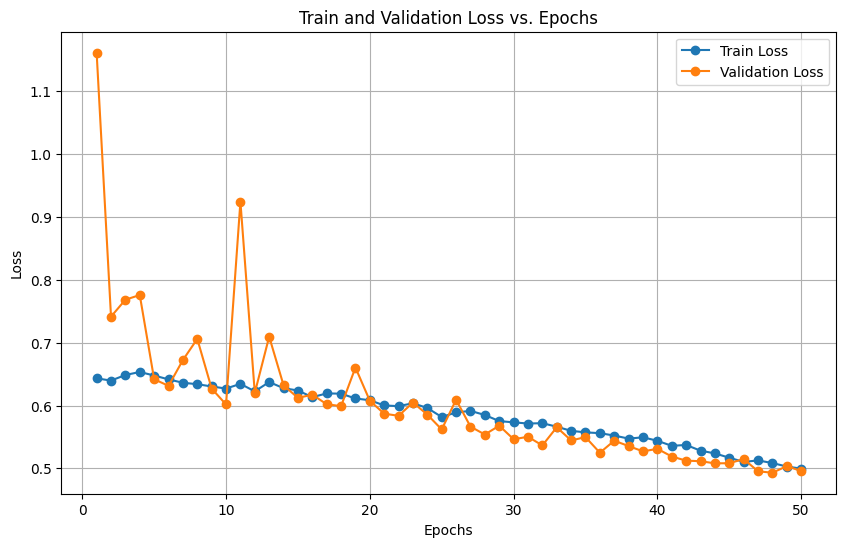

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the results.csv files for each fold
results_csv_paths = [
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_1/class_fold_1/results.csv',
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_2/class_fold_2/results.csv',
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_3/class_fold_3/results.csv',
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_4/class_fold_4/results.csv',
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_5/class_fold_5/results.csv'
]

# Read and combine the results.csv files for each fold
dataframes = [pd.read_csv(csv_path) for csv_path in results_csv_paths]
combined_metrics = pd.concat(dataframes, ignore_index=True)

# Group by epoch and compute the mean for train loss and validation loss
mean_metrics = combined_metrics.groupby('epoch')[['train/loss', 'val/loss']].mean()

# Plot the train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(mean_metrics.index, mean_metrics['train/loss'], marker='o', label='Train Loss')
plt.plot(mean_metrics.index, mean_metrics['val/loss'], marker='o', label='Validation Loss')

# Graph details
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


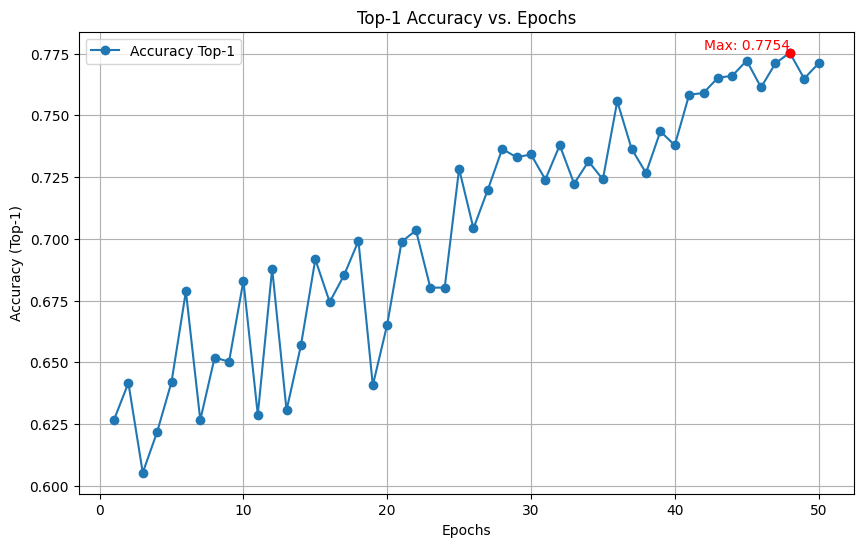

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the results.csv files for each fold
results_csv_paths = [
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_1/class_fold_1/results.csv',
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_2/class_fold_2/results.csv',
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_3/class_fold_3/results.csv',
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_4/class_fold_4/results.csv',
    '/content/drive/MyDrive/kaggle_dataset/kfold_training_outputs1/fold_5/class_fold_5/results.csv'
]

# Read and combine the results.csv files for each fold
dataframes = [pd.read_csv(csv_path) for csv_path in results_csv_paths]
combined_metrics = pd.concat(dataframes, ignore_index=True)

# Group by epoch and compute the mean for accuracy
mean_metrics = combined_metrics.groupby('epoch')[['metrics/accuracy_top1']].mean()

# Find the epoch and value of the highest accuracy
max_epoch = mean_metrics['metrics/accuracy_top1'].idxmax()
max_accuracy = mean_metrics['metrics/accuracy_top1'].max()

# Plot the Top-1 Accuracy vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(mean_metrics.index, mean_metrics['metrics/accuracy_top1'], marker='o', label='Accuracy Top-1')

# Highlight the highest accuracy point
plt.scatter(max_epoch, max_accuracy, color='red', zorder=3)
plt.text(max_epoch, max_accuracy, f'Max: {max_accuracy:.4f}', fontsize=10, color='red', ha='right', va='bottom')

# Graph details
plt.xlabel('Epochs')
plt.ylabel('Accuracy (Top-1)')
plt.title('Top-1 Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
